In [396]:
from tqdm import tqdm
import scipy
import rdata
from sklearn.model_selection import train_test_split
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

import numpyro
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoDelta, AutoNormal
from optax import adam, chain, clip

from numpyro import distributions as dist

import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy import linalg




numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_x64()

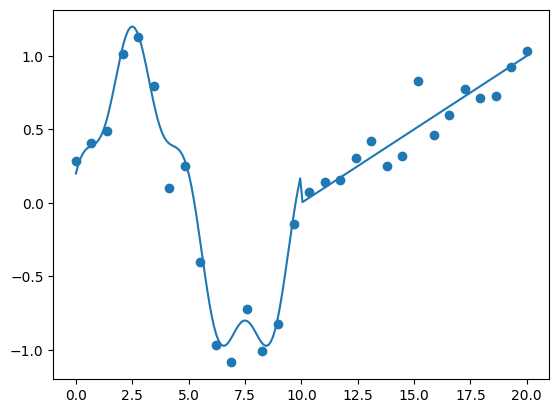

In [397]:
X_train = np.linspace(0,20,30).reshape(-1,1)
ind = (X_train<10)
y_train = (ind*1.0)*(np.sin(np.pi*X_train/5.0) + 0.2*np.cos(4.0*np.pi*X_train/5.0)) \
    + (np.invert(ind)*1.0)*(X_train/10.0 - 1.0) 
y_train = y_train.squeeze()
np.random.seed(70)
y_train = y_train + 0.1*np.random.normal(size=y_train.shape)

X_test = np.linspace(0,20,200).reshape(-1,1)
ind = (X_test<10)
y_test = (ind*1.0)*(np.sin(np.pi*X_test/5.0) + 0.2*np.cos(4.0*np.pi*X_test/5.0)) \
    + (np.invert(ind)*1.0)*(X_test/10.0 - 1.0) 
y_test = y_test.squeeze()

plt.scatter(X_train,y_train)
plt.plot(X_test,y_test)

# GP using gpytorch

In [431]:
import math
import torch
import gpytorch

Xtrain_torch = torch.from_numpy(X_train)
Ytrain_torch = torch.from_numpy(y_train).squeeze(-1)

Xtest_torch = torch.from_numpy(X_test)
Ytest_torch = torch.from_numpy(y_test).squeeze(-1)

In [521]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        lengthscale_prior = gpytorch.priors.GammaPrior(1, 1)
        outputscale_prior = gpytorch.priors.GammaPrior(1, 2)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(
            ard_num_dims=Xtrain_torch.shape[1],
            lengthscale_prior = lengthscale_prior
            )
            ,outputscale_prior = outputscale_prior,
            )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.GammaPrior(1, 1))
model_gpy = ExactGPModel(Xtrain_torch, Ytrain_torch, likelihood)

hypers = {
    'likelihood.noise_covar.noise': torch.tensor(0.5),
    'covar_module.base_kernel.lengthscale': torch.tensor(0.5)*torch.ones(X_train.shape[1],1),
    # 'covar_module.base_kernel.lengthscale': torch.tensor([1.6910,0.4038, 2.2482,2.2176,0.8974,0.2249]),
    'covar_module.outputscale': torch.tensor(1.),
}

model_gpy.initialize(**hypers);

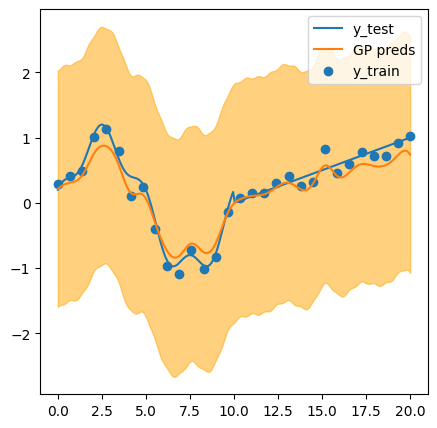

In [522]:
# posterior predictions before fitting/learning the hyperparameters (before "training")

model_gpy.eval()
# likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_preds = likelihood(model_gpy(Xtest_torch))    # prediccion de las ytest (no ftest) ya que estamos usando likelihood()
    train_preds = likelihood(model_gpy(Xtrain_torch)) # prediccion de las ytrain (no ftrain) ya que estamos usando likelihood()

mean_preds_test = test_preds.mean.numpy()
mean_preds_train = train_preds.mean.numpy()
upper, lower = test_preds.confidence_region()
upper = upper.numpy()
lower = lower.numpy()

fig,ax = plt.subplots(figsize=(5,5),nrows=1,ncols=1)

ax.plot(X_test,y_test,label = "y_test")
ax.plot(X_test,mean_preds_test,label = "GP preds")
ax.fill_between(X_test.squeeze(),lower,upper,color="orange",alpha=0.5)
ax.scatter(X_train,y_train,label = "y_train")
ax.legend();



In [524]:
# %%script true
model_gpy.train()
with torch.no_grad():
    K_prior_untrained  = likelihood(model_gpy(Xtrain_torch)).covariance_matrix.numpy() # asi puedo extraer la kernel matrix antes de entrenar 
    # K_prior_untrained  = model_gpy(Xtrain_torch).covariance_matrix.numpy() # if we don't want the noise in the diagonal
K_prior_untrained

array([[1.50000000e+000, 3.86258473e-001, 2.22593295e-002,
        1.91382479e-004, 2.45498201e-007, 4.69840543e-011,
        1.34155569e-015, 5.71508850e-021, 3.63239655e-027,
        3.44444764e-034, 4.87306225e-042, 1.02858544e-050,
        3.23917805e-060, 1.52189718e-070, 1.06682170e-081,
        1.11571792e-093, 1.74089675e-106, 4.05272992e-120,
        1.40759705e-134, 7.29398848e-150, 5.63907456e-166,
        6.50439100e-183, 1.11933861e-200, 2.87390471e-219,
        1.10087823e-238, 6.29161654e-259, 5.36464817e-280,
        6.82458556e-302, 0.00000000e+000, 0.00000000e+000],
       [3.86258473e-001, 1.50000000e+000, 3.86258473e-001,
        2.22593295e-002, 1.91382479e-004, 2.45498201e-007,
        4.69840543e-011, 1.34155569e-015, 5.71508850e-021,
        3.63239655e-027, 3.44444764e-034, 4.87306225e-042,
        1.02858544e-050, 3.23917805e-060, 1.52189718e-070,
        1.06682170e-081, 1.11571792e-093, 1.74089675e-106,
        4.05272992e-120, 1.40759705e-134, 7.29398848e-1

In [509]:
training_iter = 100

model_gpy.train()
likelihood.train()   

# Use the adam optimizer
optimizer = torch.optim.Adam(model_gpy.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_gpy)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model_gpy(Xtrain_torch)  # this is for computing the prior GP model
    # Calc loss and backprop gradients
    loss = -mll(output, Ytrain_torch)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f outputscale %.3f noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model_gpy.covar_module.outputscale.item(),
        model_gpy.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 1.268 outputscale 1.000 noise: 0.500
Iter 2/100 - Loss: 1.211 outputscale 0.938 noise: 0.462
Iter 3/100 - Loss: 1.157 outputscale 0.878 noise: 0.426
Iter 4/100 - Loss: 1.106 outputscale 0.821 noise: 0.392
Iter 5/100 - Loss: 1.056 outputscale 0.767 noise: 0.361
Iter 6/100 - Loss: 1.007 outputscale 0.715 noise: 0.331
Iter 7/100 - Loss: 0.957 outputscale 0.665 noise: 0.304
Iter 8/100 - Loss: 0.906 outputscale 0.619 noise: 0.278
Iter 9/100 - Loss: 0.856 outputscale 0.575 noise: 0.254
Iter 10/100 - Loss: 0.808 outputscale 0.534 noise: 0.232
Iter 11/100 - Loss: 0.761 outputscale 0.496 noise: 0.212
Iter 12/100 - Loss: 0.717 outputscale 0.460 noise: 0.193
Iter 13/100 - Loss: 0.675 outputscale 0.427 noise: 0.175
Iter 14/100 - Loss: 0.635 outputscale 0.397 noise: 0.159
Iter 15/100 - Loss: 0.595 outputscale 0.369 noise: 0.145
Iter 16/100 - Loss: 0.557 outputscale 0.343 noise: 0.131
Iter 17/100 - Loss: 0.520 outputscale 0.320 noise: 0.119
Iter 18/100 - Loss: 0.486 outputscale 0.

In [510]:
# Get into evaluation (predictive posterior) mode
model_gpy.eval()
# likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_preds = likelihood(model_gpy(Xtest_torch))    # prediccion de las ytest (no ftest) ya que estamos usando likelihood()
    train_preds = likelihood(model_gpy(Xtrain_torch)) # prediccion de las ytrain (no ftrain) ya que estamos usando likelihood()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [511]:
%%script true
# this is the constant prior mean at the training inputs after fitting the hyperparameters
plt.scatter(X_train,model_gpy.forward(Xtrain_torch).loc.detach().numpy())
# model_gpy.train();
# plt.scatter(X_train,likelihood(model_gpy(Xtrain_torch)).loc.detach().numpy())  # this should be the same thing
# this is the posterior mean at the training inputs after fitting the hyperparameters
plt.scatter(X_train,train_preds.loc.numpy())

In [512]:
%%script true
# if the model is in training mode, calling it will return the Gaussian prior distribution
model_gpy.train()
K_prior_after_fitting = likelihood(model_gpy(Xtrain_torch)).covariance_matrix
print(K_prior_after_fitting)

# if the model is in evaluation mode, calling it will return the Gaussian posterior distribution
model_gpy.eval()
K_post_after_fitting = likelihood(model_gpy(Xtrain_torch)).covariance_matrix

In [513]:
# computing the average standardized negative log-likelihood of the points wrt their univariate predictive densities
test_msll = gpytorch.metrics.mean_standardized_log_loss(test_preds, Ytest_torch)
train_msll = gpytorch.metrics.mean_standardized_log_loss(train_preds, Ytrain_torch)

print(f'Test MLPD: {-test_msll:.4f}, \nTraining MLPD: {-train_msll:.4f}')
print('These are not the standardized log-losses since we did not pass the Ytrain!')

Test MLPD: 0.4785, 
Training MLPD: 0.3663
These are not the standardized log-losses since we did not pass the Ytrain!


In [514]:
test_mse = gpytorch.metrics.mean_squared_error(test_preds, Ytest_torch, squared=True)
train_mse = gpytorch.metrics.mean_squared_error(train_preds, Ytrain_torch, squared=True)

print(f'Test MSE: {test_mse:.6f}, \nTraining MSE: {train_mse:.6f}')

Test MSE: 0.013971, 
Training MSE: 0.023596


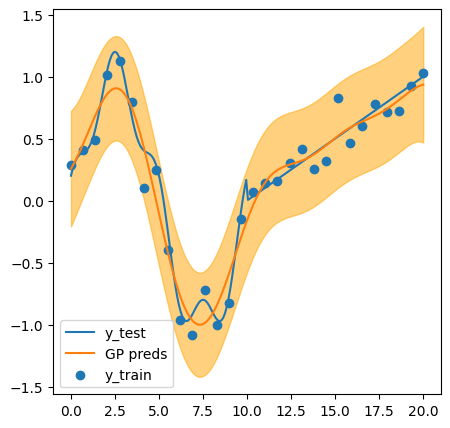

In [515]:
mean_preds_test = test_preds.mean.numpy()
mean_preds_train = train_preds.mean.numpy()
upper, lower = test_preds.confidence_region()
upper = upper.numpy()
lower = lower.numpy()

fig,ax = plt.subplots(figsize=(5,5),nrows=1,ncols=1)

ax.plot(X_test,y_test,label = "y_test")
ax.plot(X_test,mean_preds_test,label = "GP preds")
ax.fill_between(X_test.squeeze(),lower,upper,color="orange",alpha=0.5)
ax.scatter(X_train,y_train,label = "y_train")
ax.legend();



# PoGPE

In [254]:
S = 100                                 # number of spectral frequencies
DIM = X_train.shape[1]                  # dimension of the input vector


np.random.seed(0)
Omega_fixed= jnp.asarray(np.random.randn(S*DIM)).reshape(S,DIM)

In [255]:
def myfun(A,B):
    return (A @ B).squeeze()

matmul_vmapped = jax.vmap(myfun, in_axes=(0, 0))


def pogpe_with_RFGP_fixed_Omega(X, M=2, Omega_fixed = Omega_fixed, Y=None, Ytest=None):              # M is the number of experts
    N = X.shape[0]
    DIM = X.shape[1]
    S = Omega_fixed.shape[0]    # number of spectral frequencies

    #########################
    # RF-GP for the experts #
    #########################
    with numpyro.plate("M", M, dim=-2):
        var_mu_ex = numpyro.sample("kernel_var_exp_mean", dist.HalfNormal(1.0))
        # noise_mu_ex = numpyro.sample("kernel_noise_exp_mean", dist.InverseGamma(5.0, 5.0))
        std_ex_un = numpyro.sample('std_ex_un', dist.InverseGamma(5.0, 5.0))
        std_ex = numpyro.deterministic('std_ex', jnp.tile(jnp.reshape(std_ex_un, (-1, 1)), N))

        with numpyro.plate('2S', 2*S):
            theta_mu_ex = numpyro.sample("theta_mu_ex", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with  numpyro.plate('DIM', DIM):
            lengthscale_ex = numpyro.sample('ell_ex', dist.HalfNormal(scale = 1.0))

            
    assert lengthscale_ex.shape == (M,DIM)
    assert Omega_fixed.shape == (S,DIM)

    #### OMEGA FIXED
    vdivide =  jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))                                                                                                                            
    Omega_ex = vdivide( Omega_fixed, lengthscale_ex)     # shape = (M,S,DIM)
    ########
    assert Omega_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(Omega_ex, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    #assert ola.shape == (M,N,S)
    Phi_ex = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_ex = 1/jnp.sqrt(S)*Phi_ex  # se me habia olvidado dividir entre jnp.sqrt(S)
    assert Phi_ex.shape == (M, N, 2*S)
    assert std_ex.shape == (M,N)
    assert theta_mu_ex.shape == (M,2*S)

    # theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex+ noise_mu_ex),2*S) * theta_mu_ex
    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu_ex),2*S) * theta_mu_ex
    mu_ex = numpyro.deterministic("mu_ex", matmul_vmapped(Phi_ex,theta_mu_ex) )                 # shape = (M,Ndata)
    assert mu_ex.shape == (M,N)



    #########################
    # RF-GP for log weights #
    #########################
    with numpyro.plate("M", M, dim=-2):
        # set uninformative log-normal priors on our three kernel hyperparameters
        var_logw = numpyro.sample("kernel_var_logw", dist.HalfNormal(1.0))
        # noise_logw = numpyro.sample("kernel_noise_logw", dist.InverseGamma(5.0, 5.0))

        with numpyro.plate('2S', 2*S):
            theta_logw = numpyro.sample("theta_logw", dist.Normal(loc=0.0, 
                                                        scale=1.0)) # I'm not considering signal power here!
            
        with numpyro.plate("DIM", DIM):
            lengthscale_logw = numpyro.sample('ell_logw', dist.HalfNormal(scale = 1.0))

    assert lengthscale_logw.shape == (M,DIM)

    # theta_logw = jnp.tile(jnp.sqrt(var_logw+ noise_logw),2*S) * theta_logw
    theta_logw = jnp.tile(jnp.sqrt(var_logw),2*S) * theta_logw
    assert theta_logw.shape == (M,2*S)


    Omega_logw = vdivide( Omega_fixed, lengthscale_logw)     # shape = (M,S,DIM)
    ola = X @ jnp.transpose(Omega_logw, axes=(0,2,1))     # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)

    Phi_logw = jnp.concatenate([jnp.sin(ola), jnp.cos(ola)], axis=2)  # tiene shape = (M, Ndata, 2*S)
    Phi_logw = 1/jnp.sqrt(S)*Phi_logw  # se me habia olvidado dividir entre jnp.sqrt(S)

    logw = numpyro.deterministic("logw", matmul_vmapped(Phi_logw, theta_logw) - jnp.log(M))   # PRIOR MEAN FUNCTION!
    assert logw.shape == (M,N)


    ################################################
    # Fuse with generalized multiplicative pooling #
    ################################################
    w = numpyro.deterministic("w", jnp.exp(logw) )                 # shape = (M,Ndata)
    w  = w.T
    tau_ex = 1. / std_ex


    tau_fused = numpyro.deterministic(
        "tau_fused", jnp.einsum("nm,mn->m", tau_ex, w)
    )  # N,
    assert tau_fused.shape == (N,)

    mu_fused = numpyro.deterministic(
        "mean_fused", jnp.einsum("nm,nm,mn->m", tau_ex, mu_ex, w) / tau_fused
    )  # N,
    assert mu_fused.shape == (N,)
    
    std_fused = numpyro.deterministic("std_fused", 1 / jnp.sqrt(tau_fused))
    assert std_fused.shape == (N,)

    # ESTO ES NUEVO: QUIERO INCLUIR UN RUIDO GAUSSIANO AL FINAL DE LA FUSION
    # std_noise_un = numpyro.sample('std_noise_un', dist.Gamma(1.0, 0.5))
    # std_noise = numpyro.deterministic('std_noise', jnp.tile(jnp.reshape(std_noise_un, (-1, 1)), N))
    

    numpyro.sample(
        "Ytest",
        dist.Normal(loc=jnp.squeeze(mu_fused), 
                    scale=jnp.squeeze(std_fused),
                    # scale=jnp.sqrt(jnp.squeeze(std_fused)**2 + jnp.squeeze(std_noise)**2),  # NUEVO
                    ),
        obs=Y,
    )

    if Ytest is not None:
        # compute the lpd of the observations
        numpyro.deterministic("lpd_point", jax.scipy.stats.norm.logpdf(
                jnp.squeeze(Ytest), 
                loc=jnp.squeeze(mu_fused), 
                scale=jnp.squeeze(std_fused),
                # scale = jnp.sqrt(jnp.squeeze(std_fused)**2 + jnp.squeeze(std_noise)**2),  # NUEVO
                )
            )


100%|██████████| 5000/5000 [00:02<00:00, 1679.41it/s, init loss: 1202.0935, avg. loss [4751-5000]: 1066.1685]


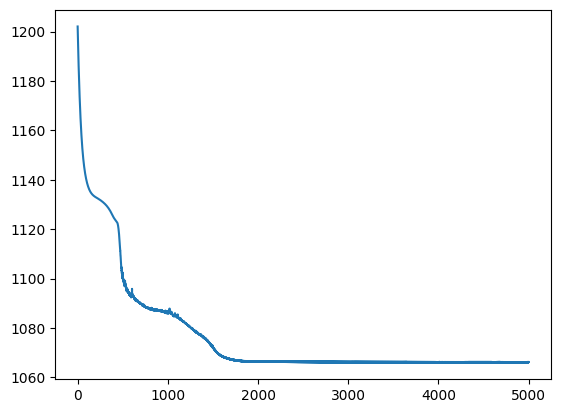

In [256]:
svi= SVI(
        pogpe_with_RFGP_fixed_Omega,
        AutoDelta(pogpe_with_RFGP_fixed_Omega, 
                  init_loc_fn = numpyro.infer.initialization.init_to_median),
                # init_loc_fn = numpyro.infer.initialization.init_to_uniform),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam (overfitting is huge with this optimizer...)
        optim=chain(clip(10.0), adam(0.005)),
        # optim=numpyro.optim.
        # optim=adam(0.001),
        loss=Trace_ELBO(),
    )

num_models = 3

res_pogpe = svi.run(
    random.PRNGKey(0),
    # 20,
    5000,  # for adam
    X=X_train,
    Y=y_train,
    M=num_models,
)
plt.plot(res_pogpe[2])

In [257]:
params = res_pogpe.params
guide = AutoDelta(pogpe_with_RFGP_fixed_Omega)
# use guide to make predictive
dist_posterior_predictive = Predictive(model=pogpe_with_RFGP_fixed_Omega, 
                                       guide=guide, params=params, num_samples=1)
# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                         X=X_test, 
                                                         Y=None, 
                                                         M=num_models,
                                                         Ytest=y_test)
ymu_tst_svi = samples_posterior_predictive["mean_fused"].squeeze()
ystd_tst_svi = samples_posterior_predictive["std_fused"].squeeze()
ymu_ex_tst = samples_posterior_predictive["mu_ex"].squeeze()
w_pogpe_tst = samples_posterior_predictive["w"].squeeze()


lpd_pogpe_svi_test = samples_posterior_predictive["lpd_point"].mean()
mse_pogpe_svi_test = np.mean((ymu_tst_svi-y_test)**2)

# plt.plot(X_test.squeeze(), samples_posterior_predictive["lpd_point"].squeeze())

# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                         X=X_train, 
                                                         Y=None, 
                                                         M=num_models,
                                                         Ytest=y_train)
ymu_tr_svi = samples_posterior_predictive["mean_fused"].squeeze()
ymu_ex_tr = samples_posterior_predictive["mu_ex"].squeeze()
w_pogpe_tr = samples_posterior_predictive["w"].squeeze()


lpd_pogpe_svi_train = samples_posterior_predictive["lpd_point"].mean()
mse_pogpe_svi_train = np.mean((ymu_tr_svi-y_train)**2)

print("MLPD test: ", lpd_pogpe_svi_test)
print("MLPD train: ", lpd_pogpe_svi_train)
print("MSE test: ", mse_pogpe_svi_test)
print("MSE train: ", mse_pogpe_svi_train)

MLPD test:  2.4269458894632296
MLPD train:  2.876847248700959
MSE test:  0.0009540129947091686
MSE train:  0.0008219132471934946


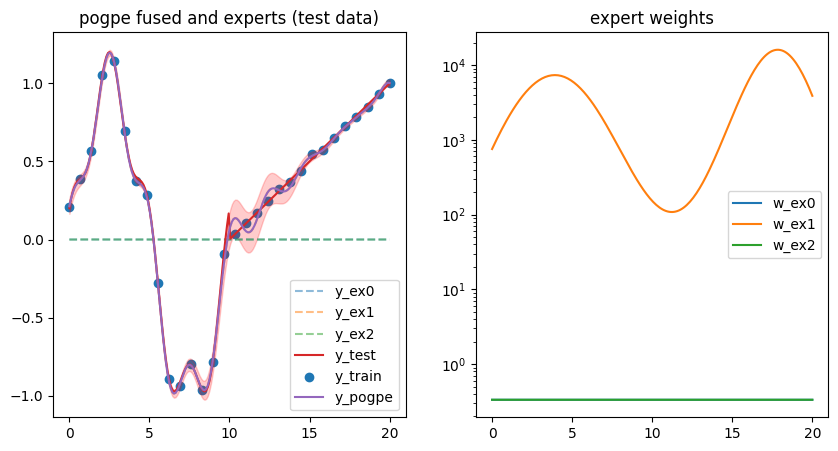

In [258]:
fig,ax = plt.subplots(figsize=(10,5), nrows=1,ncols=2)

for i in range(num_models):
    ax[0].plot(X_test, ymu_ex_tst[i,:],"--",label=f"y_ex{i}",alpha = 0.5)

ax[0].plot(X_test, y_test,label="y_test")
ax[0].scatter(X_train, y_train,label="y_train")
ax[0].plot(X_test, ymu_tst_svi,label="y_pogpe")
ax[0].fill_between(X_test.squeeze(),ymu_tst_svi+2*ystd_tst_svi,ymu_tst_svi-2*ystd_tst_svi,color="red",alpha=0.2)

ax[0].legend();
ax[0].set_title("pogpe fused and experts (test data)");


for i in range(num_models):
    ax[1].semilogy(X_test, w_pogpe_tst[i,:],"-",label=f"w_ex{i}")
ax[1].set_title("expert weights");
ax[1].legend();   


In [194]:
%%script true
plt.plot(X_test, ymu_ex_tst[0,:])

In [259]:
%%script true

fig,ax = plt.subplots(figsize=(10,5), nrows=1,ncols=2)

N=y_train.shape[0]
for i in range(num_models):
    ax[0].plot(X_train, ymu_ex_tr[i,:],"--",label=f"y_ex{i}",alpha = 0.5)

ax[0].scatter(X_train, y_train,label="y_train",alpha = 1)
ax[0].plot(X_train, ymu_tr_svi,label="y_pogpe",alpha = 1)

ax[0].legend();
ax[0].set_title("pogpe fused and experts (training data)");


for i in range(num_models):
    ax[1].semilogy(X_train, w_pogpe_tr[i,:],"-",label=f"w_ex{i}")
ax[1].set_title("expert weights");
ax[1].legend();


# MoGPE

In [260]:
S = 100                                 # number of spectral frequencies
DIM = X_train.shape[1]                  # dimension of the input vector


np.random.seed(0)
Omega_fixed= jnp.asarray(np.random.randn(S*DIM)).reshape(S,DIM)

In [270]:
def myfun(A,B):
    return (A @ B).squeeze()

matmul_vmapped = jax.vmap(myfun, in_axes=(0, 0))


def mogpe_with_RFGP_fixed_Omega(X, M=None, Omega_fixed=Omega_fixed, Y=None):
    # M is the number of experts
    # S is the number of spectral frequencies = one half of number of basis functions
    S = Omega_fixed.shape[0]

    with numpyro.plate("M", M, dim=-2):
        var_mu = numpyro.sample("kernel_var_mu_ex", dist.HalfNormal(1.0))
        # noise_mu = numpyro.sample("kernel_noise_mu_ex",dist.InverseGamma(5.0, 5.0))

        var_logstd = numpyro.sample("kernel_var_logstd_ex", dist.HalfNormal(1.0))
        # noise_logstd = numpyro.sample("kernel_noise_logstd_ex",dist.InverseGamma(5.0, 5.0))

        with numpyro.plate("2S", 2 * S):
            theta_mu_ex = numpyro.sample(
                "theta_mu_ex", dist.Normal(loc=0.0, scale=1.0)
            )  # I'm not considering signal power here!
            theta_logstd_ex = numpyro.sample(
                "theta_logstd_ex", dist.Normal(loc=0.0, scale=1.0)
            )  # I'm not considering signal power here!
        with numpyro.plate("DIM", DIM):
            lengthscale_mu_ex = numpyro.sample("ell_mu_ex", dist.HalfNormal(scale=3.0))
            lengthscale_logstd_ex = numpyro.sample(
                "ell_logstd_ex", dist.HalfNormal(scale=1)
            )

    #### MU EX
    vdivide = jax.vmap(lambda x, y: jnp.divide(x, y), (None, 0))
    Omega_mu_ex = vdivide(Omega_fixed, lengthscale_mu_ex)  # shape = (M,S,DIM)
    ########
    # assert Omega_ex.shape == (M,S,DIM)
    ola = X @ jnp.transpose(
        Omega_mu_ex, axes=(0, 2, 1)
    )  # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    # assert ola.shape == (M,N,S)
    Phi_mu_ex = jnp.concatenate(
        [jnp.sin(ola), jnp.cos(ola)], axis=2
    )  # tiene shape = (M, Ndata, 2*S)
    Phi_mu_ex = 1 / jnp.sqrt(S) * Phi_mu_ex

    #### LOGSTD EX
    Omega_logstd_ex = vdivide(Omega_fixed, lengthscale_logstd_ex)
    ola = X @ jnp.transpose(
        Omega_logstd_ex, axes=(0, 2, 1)
    )  # this is batch matmul: (Ndata,DIM) x (M,DIM,S) = (M,Ndata,S)
    # assert ola.shape == (M,N,S)
    Phi_logstd_ex = jnp.concatenate(
        [jnp.sin(ola), jnp.cos(ola)], axis=2
    )  # tiene shape = (M, Ndata, 2*S)
    Phi_logstd_ex = 1 / jnp.sqrt(S) * Phi_logstd_ex

    assert var_mu.shape == (M, 1)
    assert theta_mu_ex.shape == (M, 2 * S)

    theta_mu_ex = jnp.tile(jnp.sqrt(var_mu), 2 * S) * theta_mu_ex
    theta_logstd_ex = jnp.tile(jnp.sqrt(var_logstd), 2 * S) * theta_logstd_ex

    mu_ex = numpyro.deterministic(
        "mu_ex", matmul_vmapped(Phi_mu_ex, theta_mu_ex)
    )  # shape = (M,Ndata)
    logstd_ex = numpyro.deterministic(
        "logstd_ex", matmul_vmapped(Phi_logstd_ex, theta_logstd_ex)
    )  # shape = (M,Ndata)
    std_ex = numpyro.deterministic("std_ex", jnp.exp(logstd_ex))  # shape = (M,Ndata)

    ################################
    # GP for unconstrained weights #
    ################################

    with numpyro.plate("M1", M - 1, dim=-2):
        var_w = numpyro.sample("kernel_var_w", dist.HalfNormal(1.0))
        with numpyro.plate("2S", 2 * S):
            theta_w = numpyro.sample(
                "theta_w",
                dist.Normal(
                    loc=0.0, scale=1.0
                ),  # I'm not considering signal power here!
            )
        with numpyro.plate("DIM", DIM):
            lengthscale_w = numpyro.sample("ell_w", dist.HalfNormal(scale=1))

    assert var_w.shape == (M - 1, 1)
    assert theta_w.shape == (M - 1, 2 * S)

    #### W_UN
    Omega_w = vdivide(Omega_fixed, lengthscale_w)
    ola = X @ jnp.transpose(Omega_w, axes=(0, 2, 1))
    Phi_w = jnp.concatenate(
        [jnp.sin(ola), jnp.cos(ola)], axis=2
    )  # tiene shape = (M, Ndata, 2*S)
    Phi_w = 1 / jnp.sqrt(S) * Phi_w

    theta_w = jnp.tile(jnp.sqrt(var_w), 2 * S) * theta_w
    w_un = matmul_vmapped(Phi_w, theta_w)  # shape = (M-1,Ndata)
    w_un = jnp.vstack([w_un, jnp.zeros(X.shape[0])])  # shape = (M,Ndata)

    log_w = jax.nn.log_softmax(w_un, axis=0)  # shape = (M,Ndata)

    # compute log-factor
    Y_rep = jnp.tile(jnp.reshape(Y, (-1, 1)), M)
    lpd_point = jax.scipy.stats.norm.logpdf(Y_rep, loc=mu_ex.T, scale=std_ex.T)
    logp = jax.nn.logsumexp(lpd_point + log_w.T, axis=1)
    numpyro.deterministic(
        "lpd_point", logp
    )  # I store the evaluation of the log-likelihood
    numpyro.deterministic("w", jnp.exp(log_w).T)
    numpyro.factor("logp", jnp.sum(logp))  # shape = (Ndata, M)

100%|██████████| 5000/5000 [00:04<00:00, 1206.61it/s, init loss: 2756.1839, avg. loss [4751-5000]: 1541.7658]


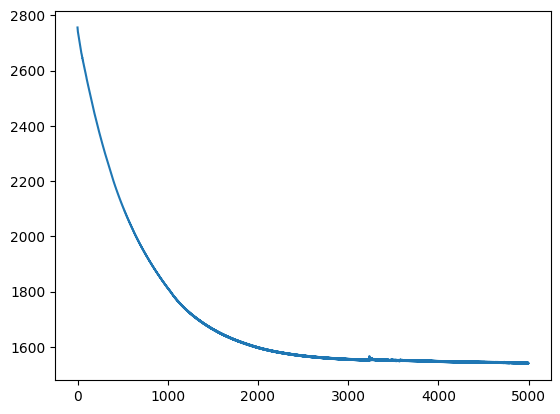

In [271]:
M_models=3
svi= SVI(
        mogpe_with_RFGP_fixed_Omega,
        AutoDelta(mogpe_with_RFGP_fixed_Omega, 
                  # init_loc_fn = numpyro.infer.initialization.init_to_median
                init_loc_fn=numpyro.infer.initialization.init_to_uniform
                  ),
        # optim = numpyro.optim.Minimize(),  # Using lbfgs instead of adam
        optim=chain(clip(10.0), adam(0.001)),
        loss=Trace_ELBO(),
    )

res_mogpe = svi.run(
    random.PRNGKey(0),
    # 5,
    5000,  # these many iterations when using adam optimizer
    X_train,
    Y=y_train,
    M=M_models,
)

plt.plot(res_mogpe[2]);


In [272]:
params = res_mogpe.params
guide = AutoDelta(mogpe_with_RFGP_fixed_Omega)
# use guide to make predictive
dist_posterior_predictive = Predictive(model=mogpe_with_RFGP_fixed_Omega, 
                                       guide=guide, params=params, num_samples=1)
# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                         X=X_test, 
                                                         Y=y_test, 
                                                         M=M_models,
                                                         )
ymu_experts = samples_posterior_predictive["mu_ex"].squeeze()  # tiene shape (M_models, y_test.shape[0])
ystd_experts = samples_posterior_predictive["std_ex"].squeeze()
w_experts_test = samples_posterior_predictive["w"].squeeze()   # tiene shape (y_test.shape[0], M_models)

ymu_mogpe = jnp.sum(jnp.multiply(ymu_experts,w_experts_test.T),axis=0)

lpd_mogpe_svi_test = samples_posterior_predictive["lpd_point"].mean()
mse_mogpe_svi_test = np.mean((ymu_mogpe-y_test)**2)

print("MLPD test data: ", lpd_mogpe_svi_test)
print("MSE test data: ", mse_mogpe_svi_test)

MLPD test data:  -0.8950278250858783
MSE test data:  0.1706942505989605


In [273]:
# these are not actual samples but just the MAP estimates (since we are using AutoDelta)
samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                         X=X_train, 
                                                         Y=y_train, 
                                                         M=M_models,
                                                         )
ymu_experts_train = samples_posterior_predictive["mu_ex"].squeeze()  # tiene shape (M_models, y_test.shape[0])
w_experts_train = samples_posterior_predictive["w"].squeeze()   # tiene shape (y_test.shape[0], M_models)

ymu_mogpe_train = jnp.sum(jnp.multiply(ymu_experts_train,w_experts_train.T),axis=0)

lpd_mogpe_svi_train = samples_posterior_predictive["lpd_point"].mean()
mse_mogpe_svi_train = np.mean((ymu_mogpe_train-y_train)**2)

print("MLPD training data: ", lpd_mogpe_svi_train)
print("MSE training data: ", mse_mogpe_svi_train)

MLPD training data:  2.9929343245247737
MSE training data:  0.17554169009316545


In [274]:
%%script true
N_samples = 250
N_points = X_test.shape[0]

samples = np.zeros((N_samples, N_points))

# TODO: Do this better
for n_sample in tqdm(range(N_samples)):
    for n_point in range(N_points):
        z = np.random.choice(
            w_experts_test.shape[2],
            p=w_samples[n_sample, n_point] / np.sum(w_samples[n_sample, n_point]),
        )
        samples[n_sample, n_point] = (
            mu_preds[n_sample, z, n_point]
            + np.random.randn() * std_preds[n_sample, z, n_point]
        )

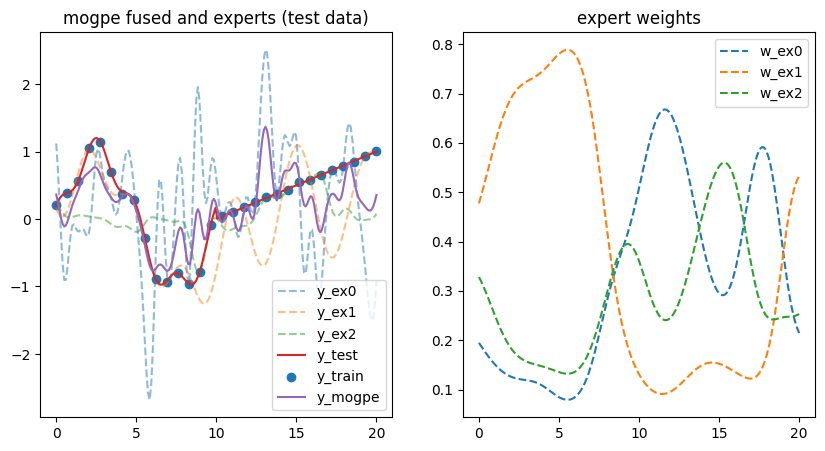

In [275]:
fig,ax = plt.subplots(figsize=(10,5),nrows=1,ncols=2)

for i in range(M_models):
    ax[0].plot(X_test, ymu_experts[i,:],'--',label=f"y_ex{i}",alpha = 0.5)

ax[0].plot(X_test, y_test,label="y_test",alpha=1)
ax[0].scatter(X_train, y_train,label="y_train",alpha=1)
ax[0].plot(X_test, ymu_mogpe,label="y_mogpe",alpha=1)
# ax[0].fill_between(X_test)
ax[0].legend();


ax[0].set_title("mogpe fused and experts (test data)")


for i in range(M_models):
    ax[1].plot(X_test, w_experts_test[:,i],'--',label=f"w_ex{i}")
ax[1].legend();
ax[1].set_title("expert weights");

In [276]:
%%script true
fig,ax = plt.subplots(figsize=(10,5),nrows=1,ncols=2)

for i in range(M_models):
    ax[0].plot(X_train, ymu_experts_train[i,:],'--',label=f"y_ex{i}",alpha = 0.5)


ax[0].scatter(X_train, y_train,label="y_train",alpha=1)
ax[0].plot(X_train, ymu_mogpe_train,label="y_mogpe",alpha=1)
ax[0].legend();
ax[0].set_title("mogpe fused and experts on training data")

for i in range(M_models):
    ax[1].plot(X_train, w_experts_train[:,i],'--',label=f"w_ex{i}")
ax[1].legend();
ax[1].set_title("expert weights")


## mogpe with mcmc

In [277]:
new_dict = {}
for key, value in params.items():
    # print(key)
    new_key = key.replace("_auto_loc","")
    new_dict[f"{new_key}"] = value
    # print(new_key)
    # print(value)

In [280]:

miMCMC = NUTS(
    mogpe_with_RFGP_fixed_Omega,
    max_tree_depth=2,
    # find_heuristic_step_size=True,
    # init_strategy=numpyro.infer.initialization.init_to_median,
    init_strategy=numpyro.infer.init_to_value(values=new_dict)
)

fer = MCMC(
    miMCMC,
    num_chains=4,
    num_samples=500,
    num_warmup=2000,
    thinning=1,
    progress_bar=True,
    chain_method="parallel",
)

fer.run(
    random.PRNGKey(0),
    X_train,
    Y=y_train,
    M=M_models,
)

miSamples_mogpe = fer.get_samples()
fer.print_summary()

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                               mean       std    median      5.0%     95.0%     n_eff     r_hat
       ell_logstd_ex[0,0]      2.52      0.00      2.52      2.52      2.53      4.19      1.99
       ell_logstd_ex[1,0]      0.91      0.00      0.91      0.90      0.92      2.22      5.94
       ell_logstd_ex[2,0]      0.45      0.00      0.45      0.45      0.46      3.12      2.74
           ell_mu_ex[0,0]      0.32      0.00      0.32      0.32      0.32      2.44      2.48
           ell_mu_ex[1,0]      1.18      0.00      1.18      1.18      1.18      2.28      3.81
           ell_mu_ex[2,0]      0.50      0.00      0.50      0.50      0.50      2.34      2.96
               ell_w[0,0]      1.31      0.01      1.31      1.30      1.32      2.03     10.67
               ell_w[1,0]      1.57      0.01      1.57      1.55      1.58      2.22      5.42
kernel_var_logstd_ex[0,0]      3.38      0.01      3.38      3.36      3.39      2.18      4.41
kernel_var_logstd_ex[1,0]      3.44    

(2000, 3, 30) (2000, 30, 3)


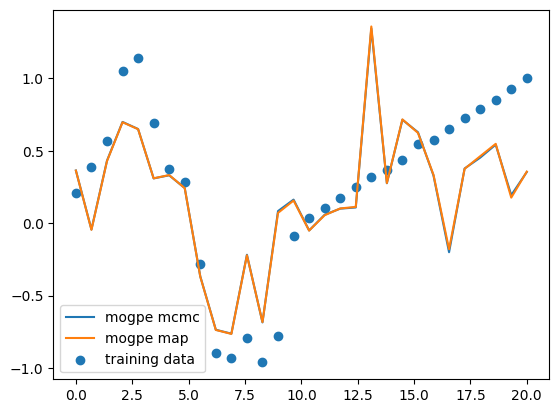

In [281]:
print(miSamples_mogpe["mu_ex"].shape, miSamples_mogpe["w"].shape)
y_fused_mcmc = jnp.mean(
    jnp.sum(
    jnp.multiply(miSamples_mogpe["mu_ex"],jnp.transpose( miSamples_mogpe["w"],axes=(0,2,1))),
    axis=1),
    axis=0,
)
plt.plot(X_train,y_fused_mcmc, label = "mogpe mcmc")
plt.plot(X_train,ymu_mogpe_train, label = "mogpe map")
plt.scatter(X_train,y_train, label = "training data")
plt.legend();


# PoGPE in serial fashion

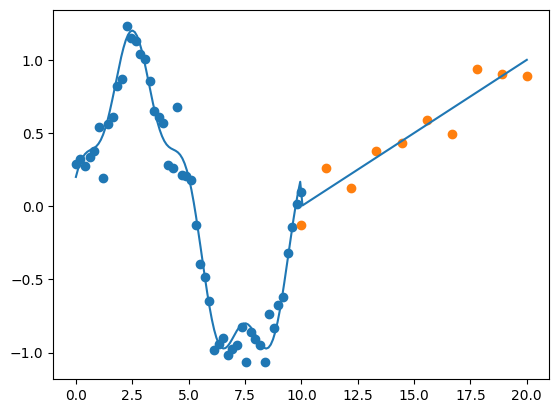

In [44]:
X_train1 = np.linspace(0,10,50).reshape(-1,1)
ind = (X_train1<10)
y_train1 = (ind*1.0)*(np.sin(np.pi*X_train1/5.0) + 0.2*np.cos(4.0*np.pi*X_train1/5.0)) \
    + (np.invert(ind)*1.0)*(X_train1/10.0 - 1.0) 
y_train1 = y_train1.squeeze()
np.random.seed(70)
y_train1 = y_train1 + 0.1*np.random.normal(size=y_train1.shape)

X_train2 = np.linspace(10,20,10).reshape(-1,1)
ind = (X_train2<10)
y_train2 = (ind*1.0)*(np.sin(np.pi*X_train2/5.0) + 0.2*np.cos(4.0*np.pi*X_train2/5.0)) \
    + (np.invert(ind)*1.0)*(X_train2/10.0 - 1.0) 
y_train2 = y_train2.squeeze()
np.random.seed(30)
y_train2 = y_train2 + 0.1*np.random.normal(size=y_train2.shape)

plt.scatter(X_train1,y_train1)
plt.scatter(X_train2,y_train2)
plt.plot(X_test,y_test);

we train PoGPE with the first set of training data and plot the experts

In [45]:
def train_and_predict_pogpe(X_train, y_train,
                            num_models = 2,
                            num_iters = 5000,
                            model = pogpe_with_RFGP_fixed_Omega,
                            init_strategy = "median",
                            values = None):
    
    if init_strategy == "median":
    
        svi= SVI(
            model,
            AutoDelta(model, 
                    init_loc_fn = numpyro.infer.initialization.init_to_median),
            optim=chain(clip(10.0), adam(0.001)),
            # optim=adam(0.001),
            loss=Trace_ELBO(),
        )
    elif init_strategy=="values":
        svi= SVI(
            model,
            AutoDelta(model, 
                    init_loc_fn = numpyro.infer.init_to_value(
                      values=values) 
                    ),
            optim=chain(clip(10.0), adam(0.001)),
            # optim=adam(0.001),
            loss=Trace_ELBO(),
        )
          

    res_pogpe = svi.run(
        random.PRNGKey(0),
        # 20,
        num_iters,  # for adam
        X=X_train,
        Y=y_train,
        M=num_models,
    )
    params = res_pogpe.params
    guide = AutoDelta(model)
    # use guide to make predictive
    dist_posterior_predictive = Predictive(model=model,guide=guide, params=params, num_samples=1)
    # these are not actual samples but just the MAP estimates (since we are using AutoDelta)
    samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                            X=X_test, 
                                                            Y=None, 
                                                            M=num_models,
                                                            Ytest=y_test)
    ymu_fused_tst = samples_posterior_predictive["mean_fused"].squeeze()
    ystd_fused_tst = samples_posterior_predictive["std_fused"].squeeze()
    ymu_ex_tst = samples_posterior_predictive["mu_ex"].squeeze()
    ystd_ex_tst = samples_posterior_predictive["std_ex"].squeeze()
    w_pogpe_tst = samples_posterior_predictive["w"].squeeze()


    # these are not actual samples but just the MAP estimates (since we are using AutoDelta)
    samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                            X=X_train, 
                                                            Y=None, 
                                                            M=num_models,
                                                            Ytest=y_train)
    ymu_fused_tr = samples_posterior_predictive["mean_fused"].squeeze()
    ystd_fused_tr = samples_posterior_predictive["std_fused"].squeeze()
    ymu_ex_tr = samples_posterior_predictive["mu_ex"].squeeze()
    ystd_ex_tr = samples_posterior_predictive["std_ex"].squeeze()
    w_pogpe_tr = samples_posterior_predictive["w"].squeeze()

    return ymu_fused_tst, ystd_fused_tst, ymu_ex_tst, ystd_ex_tst, w_pogpe_tst, params
# ymu_fused_tr, ystd_fused_tr, ymu_ex_tr, ystd_ex_tr, w_pogpe_tr


In [46]:
num_models=2
ymu_fused_tst, ystd_fused_tst, ymu_ex_tst, ystd_ex_tst, w_pogpe_tst,params= \
    train_and_predict_pogpe(X_train1, y_train1,num_models=num_models)

100%|██████████| 5000/5000 [00:01<00:00, 2769.17it/s, init loss: 454.3062, avg. loss [4751-5000]: 339.1245]


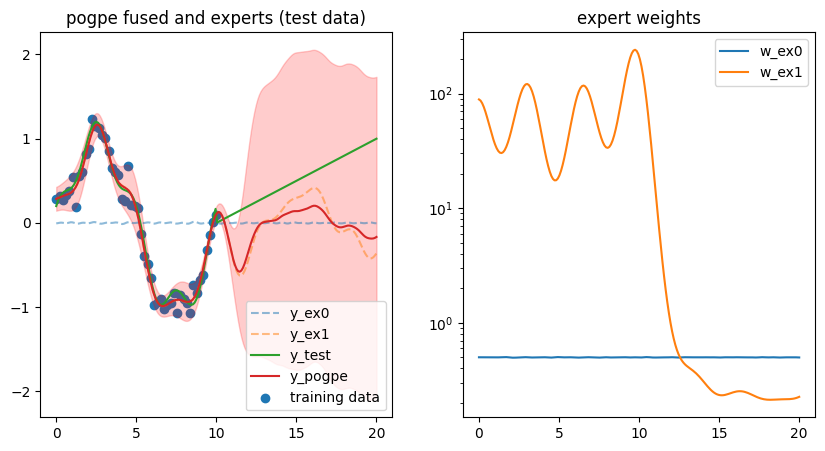

In [47]:
fig,ax = plt.subplots(figsize=(10,5), nrows=1,ncols=2)

for i in range(num_models):
    ax[0].plot(X_test, ymu_ex_tst[i,:],"--",label=f"y_ex{i}",alpha = 0.5)

ax[0].plot(X_test, y_test,label="y_test")
ax[0].plot(X_test, ymu_fused_tst,label="y_pogpe")
ax[0].scatter(X_train1,y_train1,label="training data")
ax[0].fill_between(X_test.squeeze(),ymu_fused_tst+2*ystd_fused_tst,ymu_fused_tst-2*ystd_fused_tst,color="red",alpha=0.2)

ax[0].legend();
ax[0].set_title("pogpe fused and experts (test data)");


for i in range(num_models):
    ax[1].semilogy(X_test, w_pogpe_tst[i,:],"-",label=f"w_ex{i}")
ax[1].set_title("expert weights");
ax[1].legend();   


We extract estimates of the parameters and use them to initialize the fitting of the model in the 
second training set

In [48]:
new_dict = {}
for key, value in params.items():
    # print(key)
    new_key = key.replace("_auto_loc","")
    new_dict[f"{new_key}"] = value
    # print(new_key)
    # print(value)

In [49]:
ymu_fused_tst, ystd_fused_tst, ymu_ex_tst, ystd_ex_tst, w_pogpe_tst,params= \
    train_and_predict_pogpe(X_train2, y_train2,num_iters=100,init_strategy="values",values=new_dict)

100%|██████████| 100/100 [00:00<00:00, 282.05it/s, init loss: 421.2882, avg. loss [96-100]: 399.0325]


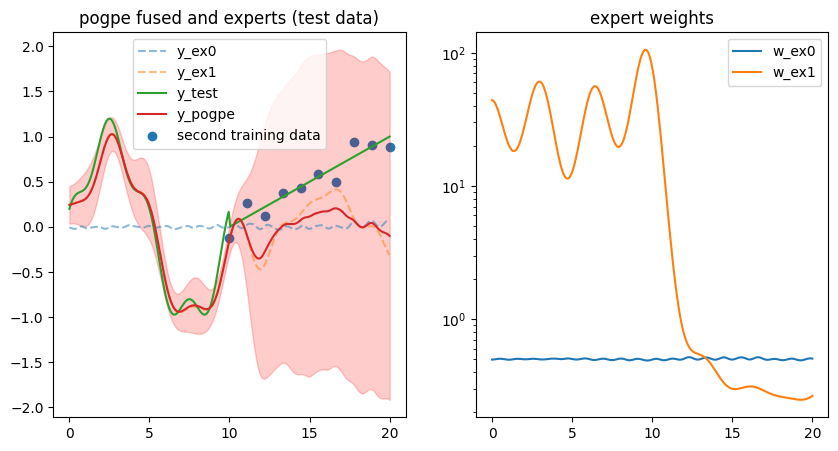

In [50]:
fig,ax = plt.subplots(figsize=(10,5), nrows=1,ncols=2)

for i in range(num_models):
    ax[0].plot(X_test, ymu_ex_tst[i,:],"--",label=f"y_ex{i}",alpha = 0.5)

ax[0].plot(X_test, y_test,label="y_test")
ax[0].plot(X_test, ymu_fused_tst,label="y_pogpe")
ax[0].scatter(X_train2,y_train2,label="second training data")
ax[0].fill_between(X_test.squeeze(),ymu_fused_tst+2*ystd_fused_tst,ymu_fused_tst-2*ystd_fused_tst,color="red",alpha=0.2)

ax[0].legend();
ax[0].set_title("pogpe fused and experts (test data)");


for i in range(num_models):
    ax[1].semilogy(X_test, w_pogpe_tst[i,:],"-",label=f"w_ex{i}")
ax[1].set_title("expert weights");
ax[1].legend();   


compare the above with a model trained on the second training dataset but without using any of the information 
from the training in the first dataset

100%|██████████| 100/100 [00:00<00:00, 286.00it/s, init loss: 405.8774, avg. loss [96-100]: 396.4914]


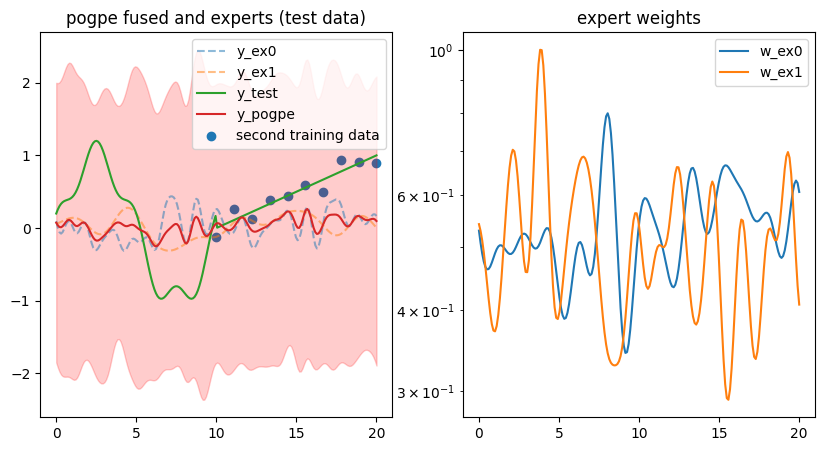

In [51]:
ymu_fused_tst, ystd_fused_tst, ymu_ex_tst, ystd_ex_tst, w_pogpe_tst,params= \
    train_and_predict_pogpe(X_train2, y_train2,num_iters=100)

fig,ax = plt.subplots(figsize=(10,5), nrows=1,ncols=2)

for i in range(num_models):
    ax[0].plot(X_test, ymu_ex_tst[i,:],"--",label=f"y_ex{i}",alpha = 0.5)

ax[0].plot(X_test, y_test,label="y_test")
ax[0].plot(X_test, ymu_fused_tst,label="y_pogpe")
ax[0].scatter(X_train2,y_train2,label="second training data")
ax[0].fill_between(X_test.squeeze(),ymu_fused_tst+2*ystd_fused_tst,ymu_fused_tst-2*ystd_fused_tst,color="red",alpha=0.2)

ax[0].legend();
ax[0].set_title("pogpe fused and experts (test data)");


for i in range(num_models):
    ax[1].semilogy(X_test, w_pogpe_tst[i,:],"-",label=f"w_ex{i}")
ax[1].set_title("expert weights");
ax[1].legend();   

# MoGPE in serial fashion

In [54]:
def train_and_predict_mogpe(X_train, y_train,
                            num_models = 2,
                            num_iters = 5000,
                            model = mogpe_with_RFGP_fixed_Omega,
                            init_strategy = "median",
                            values = None):
    
    if init_strategy == "median":
    
        svi= SVI(
            model,
            AutoDelta(model, 
                    init_loc_fn = numpyro.infer.initialization.init_to_median),
            optim=chain(clip(10.0), adam(0.001)),
            # optim=adam(0.001),
            loss=Trace_ELBO(),
        )
    elif init_strategy=="values":
        svi= SVI(
            model,
            AutoDelta(model, 
                    init_loc_fn = numpyro.infer.init_to_value(
                      values=values) 
                    ),
            optim=chain(clip(10.0), adam(0.001)),
            # optim=adam(0.001),
            loss=Trace_ELBO(),
        )
          

    res_pogpe = svi.run(
        random.PRNGKey(0),
        # 20,
        num_iters,  # for adam
        X=X_train,
        Y=y_train,
        M=num_models,
    )
    params = res_pogpe.params
    guide = AutoDelta(model)
    # use guide to make predictive
    dist_posterior_predictive = Predictive(model=model,guide=guide, params=params, num_samples=1)
    # these are not actual samples but just the MAP estimates (since we are using AutoDelta)
    samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                            X=X_test, 
                                                            Y=y_test, 
                                                            M=num_models,
                                                            )
    ymu_ex_tst = samples_posterior_predictive["mu_ex"].squeeze()  # tiene shape (M_models, y_test.shape[0])
    ystd_ex_tst = samples_posterior_predictive["std_ex"].squeeze()
    w_ex_tst = samples_posterior_predictive["w"].squeeze()   # tiene shape (y_test.shape[0], M_models)

    ymu_fused_tst = jnp.sum(jnp.multiply(ymu_ex_tst,w_ex_tst.T),axis=0)


    # these are not actual samples but just the MAP estimates (since we are using AutoDelta)
    samples_posterior_predictive = dist_posterior_predictive(random.PRNGKey(0), 
                                                            X=X_train, 
                                                            Y=y_train, 
                                                            M=num_models,
                                                            )
    ymu_ex_tr = samples_posterior_predictive["mu_ex"].squeeze()  # tiene shape (M_models, y_test.shape[0])
    ystd_ex_tr = samples_posterior_predictive["std_ex"].squeeze()
    w_ex_tr = samples_posterior_predictive["w"].squeeze()   # tiene shape (y_test.shape[0], M_models)

    ymu_fused_tr = jnp.sum(jnp.multiply(ymu_ex_tr,w_ex_tr.T),axis=0)

    return ymu_fused_tst, ymu_ex_tst, ystd_ex_tst, w_ex_tst, params
# ymu_fused_tr, ystd_fused_tr, ymu_ex_tr, ystd_ex_tr, w_pogpe_tr


In [56]:
num_models=2
ymu_fused_tst, ymu_ex_tst, ystd_ex_tst, w_ex_tst,params = \
    train_and_predict_mogpe(X_train1, y_train1,num_models=num_models)

100%|██████████| 5000/5000 [00:02<00:00, 2291.25it/s, init loss: 549.3774, avg. loss [4751-5000]: 439.8928]


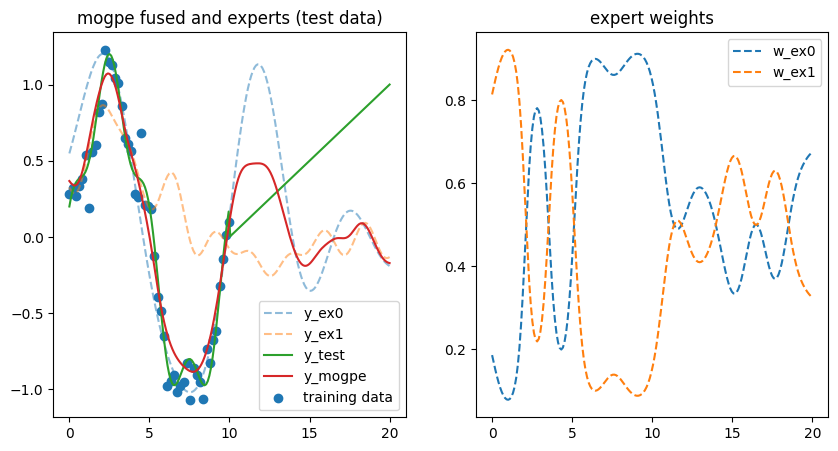

In [61]:
fig,ax = plt.subplots(figsize=(10,5),nrows=1,ncols=2)

for i in range(num_models):
    ax[0].plot(X_test, ymu_ex_tst[i,:],'--',label=f"y_ex{i}",alpha = 0.5)

ax[0].plot(X_test, y_test,label="y_test",alpha=1)
ax[0].plot(X_test, ymu_fused_tst,label="y_mogpe",alpha=1)
ax[0].scatter(X_train1,y_train1,label="training data")
ax[0].set_title("mogpe fused and experts (test data)")
ax[0].legend()


for i in range(num_models):
    ax[1].plot(X_test, w_ex_tst[:,i],'--',label=f"w_ex{i}")
ax[1].legend();
ax[1].set_title("expert weights");

In [62]:
# extracting the parameters of the model trained on (X_train1,y_train1)
new_dict = {}
for key, value in params.items():
    # print(key)
    new_key = key.replace("_auto_loc","")
    new_dict[f"{new_key}"] = value
    # print(new_key)
    # print(value)

100%|██████████| 100/100 [00:00<00:00, 234.57it/s, init loss: 525.7682, avg. loss [96-100]: 505.5276]


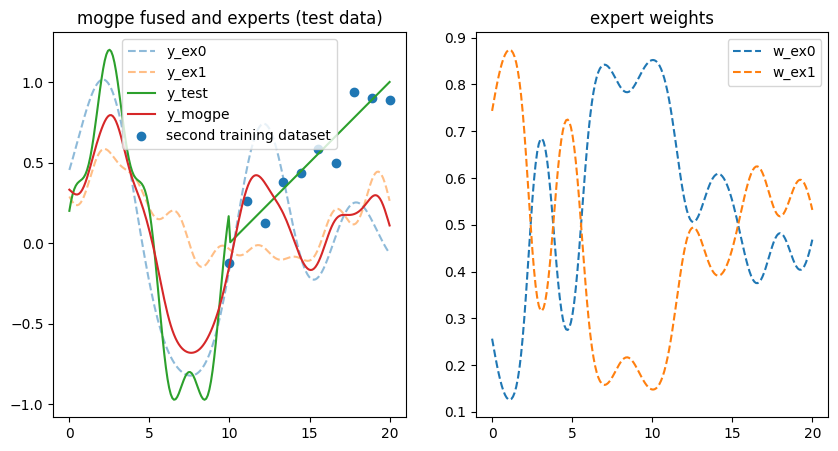

In [75]:
# training on the second training dataset using the previous values as initialization
ymu_fused_tst, ymu_ex_tst, ystd_ex_tst, w_ex_tst,params= \
    train_and_predict_mogpe(X_train2, y_train2,num_iters=100,init_strategy="values",values=new_dict)

fig,ax = plt.subplots(figsize=(10,5),nrows=1,ncols=2)

for i in range(num_models):
    ax[0].plot(X_test, ymu_ex_tst[i,:],'--',label=f"y_ex{i}",alpha = 0.5)

ax[0].plot(X_test, y_test,label="y_test",alpha=1)
ax[0].plot(X_test, ymu_fused_tst,label="y_mogpe",alpha=1)
ax[0].scatter(X_train2,y_train2,label="second training dataset")
ax[0].set_title("mogpe fused and experts (test data)")
ax[0].legend()


for i in range(num_models):
    ax[1].plot(X_test, w_ex_tst[:,i],'--',label=f"w_ex{i}")
ax[1].legend();
ax[1].set_title("expert weights");

and the following is when we trained on the second dataset without using the initalization

100%|██████████| 1000/1000 [00:00<00:00, 1809.30it/s, init loss: 504.0247, avg. loss [951-1000]: 471.7721]


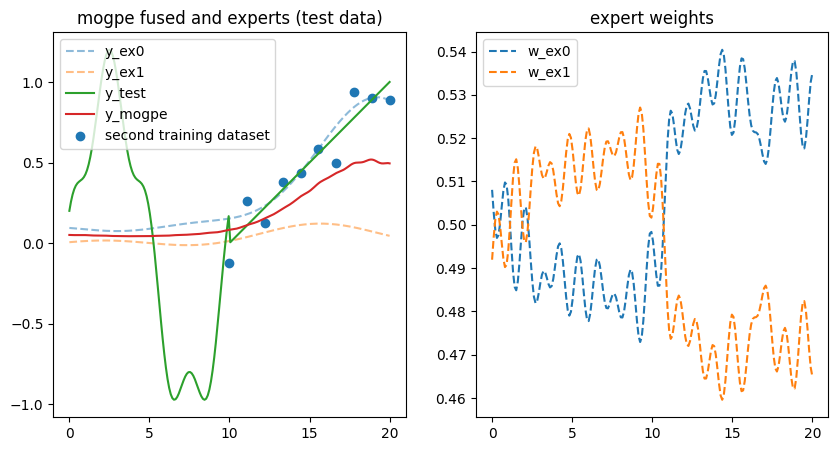

In [73]:
ymu_fused_tst, ymu_ex_tst, ystd_ex_tst, w_ex_tst,params= \
    train_and_predict_mogpe(X_train2, y_train2,num_iters=1000)

fig,ax = plt.subplots(figsize=(10,5),nrows=1,ncols=2)

for i in range(num_models):
    ax[0].plot(X_test, ymu_ex_tst[i,:],'--',label=f"y_ex{i}",alpha = 0.5)

ax[0].plot(X_test, y_test,label="y_test",alpha=1)
ax[0].plot(X_test, ymu_fused_tst,label="y_mogpe",alpha=1)
ax[0].scatter(X_train2,y_train2,label="second training dataset")
ax[0].set_title("mogpe fused and experts (test data)")
ax[0].legend()


for i in range(num_models):
    ax[1].plot(X_test, w_ex_tst[:,i],'--',label=f"w_ex{i}")
ax[1].legend();
ax[1].set_title("expert weights");